# Hypothesis Testing with Insurance Data
Author: Kim Hazed Delfino

## Imports

In [85]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats

## Load the Data

In [86]:
path = "/Users/kim/Documents/GitHub/repo/Hypothesis_Testing_With_Insurance_Data/insurance - insurance.csv"
df = pd.read_csv(path)

## Exploratory Data Analysis

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [88]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [89]:
# Check for duplicates 
df.duplicated().sum()

1

- looks like we have 1 duplicate that we need to drop to remove repeating data

In [90]:
# drop duplicate
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [91]:
# Check for Data consistency
df['sex'].value_counts()

male      675
female    662
Name: sex, dtype: int64

In [92]:
df['smoker'].value_counts()

no     1063
yes     274
Name: smoker, dtype: int64

In [93]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    324
northeast    324
Name: region, dtype: int64

- Our data now looks clean, we can proceed with Hypothesis testing

## Questions to Answer: 
- Q1. Do smokers have higher insurance charges than non-smokers?
- Q2. Are men more likely to smoke than women?
- Q3. Do different regions have different charges, on average?

### Q1 -  Do smokers have higher insurance charges than non-smokers?


#### State the Hypothesis and Null Hypothesis

- H0 (Null Hypothesis): Smokers and Non-smokers have the same insurance charges 
- HA (Alternate Hypothesis) There is Significant Difference between Smokers and Non-Smokers Insurance Charges
- Significance level of alpha = 0.05

- The Appropreate test to perform would be:
    - Since we are measuring a numeric value (Insurance Charges) 
    - and we are comparing 2 groups/samples 
    - we therefore want to perform a 2-sample t-test (independent t-test)
- 2-sample T-Test has the following assumptions:
    - No significant outliers
    - Normality
    - Equal Variance

#### Getting the Data

In [94]:
# Separate the groups 
smoker = df[df['smoker']== 'yes']
smoker.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
11,62,female,26.29,0,yes,southeast,27808.7251
14,27,male,42.13,0,yes,southeast,39611.7577
19,30,male,35.30,0,yes,southwest,36837.4670
23,34,female,31.92,1,yes,northeast,37701.8768


In [95]:
non_smoker = df[df['smoker']== 'no']
non_smoker.head()

,age,sex,bmi,children,smoker,region,charges
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160


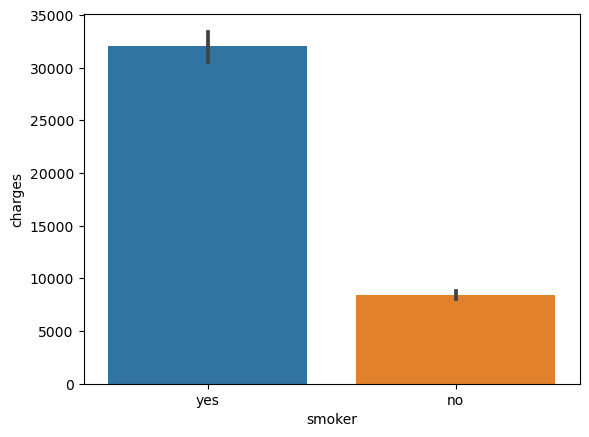

In [96]:
# Visualize means 
ax = sns.barplot(df, x = 'smoker', y='charges', errorbar=('ci',95))

In [97]:
# Create pandas series per group
smoker_charges = smoker['charges']
non_smoker_charges = non_smoker['charges']
display(smoker_charges.head(),non_smoker_charges.head())

0     16884.9240
11    27808.7251
14    39611.7577
19    36837.4670
23    37701.8768
Name: charges, dtype: float64

1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
5     3756.62160
Name: charges, dtype: float64

#### Checking for Assumptions of 2-Sample T-test
- 2-sample T-Test has the following assumptions:
    - No significant outliers
    - Normality
    - Equal Variance

In [98]:
# Checking for abs value od z-scores that are > 3
is_outlier_smoker = np.abs(stats.zscore(smoker_charges) > 3)
print(f"There are {is_outlier_smoker.sum()} outliers in the smoker group out of {len(smoker_charges)}")

There are 0 outliers in the smoker group out of 274


In [99]:
# Checking for abs value od z-scores that are > 3
is_outlier_non_smoker = np.abs(stats.zscore(non_smoker_charges) > 3)
print(f"There are {is_outlier_non_smoker.sum()} outliers in the non_smoker group out of {len(non_smoker_charges)}")

There are 24 outliers in the non_smoker group out of 1063


In [100]:
# Remove outliers in non_smoker group
non_smoker_charges = non_smoker_charges[~is_outlier_non_smoker]
print(len(non_smoker_charges))

1039


#### Check for normality 
- According to the workflow on the lp, Since both groups has n > 30, we can safely ignore the assumption of normality

#### Check for Equal Variance

In [101]:
result = stats.levene(smoker_charges,non_smoker_charges)
print(result)
print(result.pvalue<.05)

LeveneResult(statistic=520.7178262969225, pvalue=2.512613039096279e-97)
True


- According to the documentation from stats.levene, the null hypothesis for the test is that both groups have equal variance. Since our p-value is less than .05 we reject the null hypothesis and conclude tht our groups do `NOT` have equal variance.
- since we did `NOT` meet the assumption of equal variance, we will run our stats.ttest_int using equal_var = False. This will run a Welch's T-Test which designed to account for unequal variance.

#### Statistical Test

In [102]:
result = stats.ttest_ind(smoker_charges,non_smoker_charges,equal_var = False)
print(result)
print(result.pvalue<.05)

Ttest_indResult(statistic=33.723466247187815, pvalue=2.7282718648018296e-104)
True


#### Final Conclusion
- Our Welch's T-Test return a p-value < .05 we reject the null hypothesis and support the alternative hypothesis that there is a significant difference for Insurance Charges between Smoker and Non-smoker.
- we can look at the actual means of our final groups to see if they are significantly More or Less. 

In [103]:
print(f"The Average Insurance charge for smoker was {smoker_charges.mean():.2f}")
print(f"The Average Insurance charge for non-smoker is {non_smoker_charges.mean():.2f}")

The Average Insurance charge for smoker was 32050.23
The Average Insurance charge for non-smoker is 7945.92


In [104]:
# Plot the updated groups 
plot_df = pd.concat([smoker,non_smoker],axis=0)

#### Answering the Hypothesis test : Do smokers have higher insurance charges than non-smokers?
- Smoker have significantly higher insurance charges than non-smoker

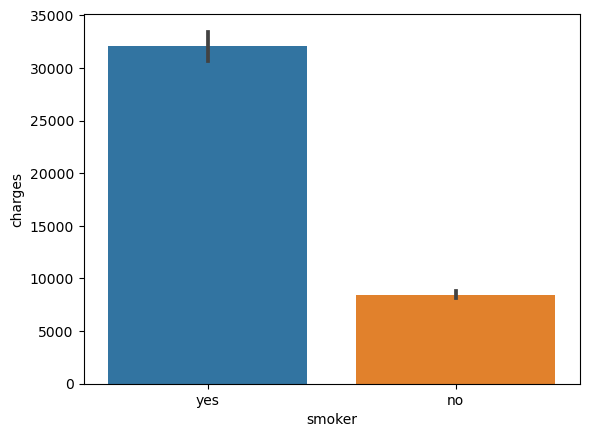

In [105]:
# Visualize means 
ax = sns.barplot(plot_df, x = 'smoker', y='charges', errorbar=('ci',95))

### Q2 -  Are men more likely to smoke than women?

#### State the Hypothesis and Null Hypothesis
- H0(Null Hypothesis): Men and Women have equal likelyhood to smoke
- HA(Alternate Hypothesis): Men have Significant likelyhood to smoke than Women
- Significance level of alpha = 0.05

- The Appropriate test to perform would be:
    - Since we're testing Categorical Data (Smokes:Yes or No)
    - and we're comparing 2 groups/samples
    - we therefore want to perform Chi-Square Test
- Assumptions for Chi-Square Test:
    - two variables should be measured ordinal or nominal level
    - two variables should consist of two or more categorical, independent groups.
    

#### Getting the Data

In [106]:
# Separate the groups 
men_df = df[df['sex']== 'male']
men_df.head()

,age,sex,bmi,children,smoker,region,charges
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
8,37,male,29.830,2,no,northeast,6406.41070


In [107]:
women_df = df[df['sex']== 'female']
women_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92400
5,31,female,25.74,0,no,southeast,3756.62160
6,46,female,33.44,1,no,southeast,8240.58960
7,37,female,27.74,3,no,northwest,7281.50560
9,60,female,25.84,0,no,northwest,28923.13692


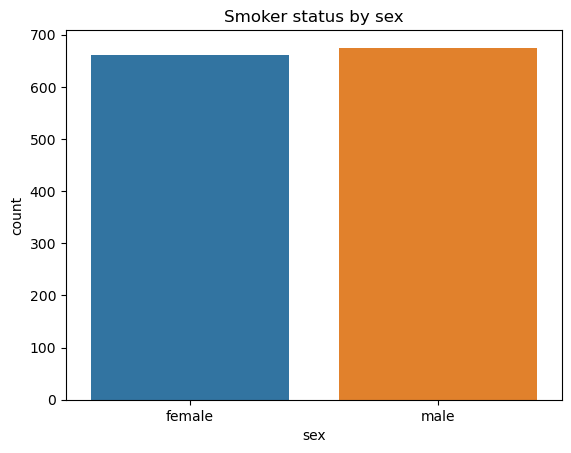

In [108]:
# Visualize male vs female
ax = sns.countplot(df, x = 'sex')
ax.set_title('Smoker status by sex');

In [109]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table



smoker,no,yes
sex,,
female,547,115
male,516,159


#### Statistical Test

In [110]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results



In [111]:
# What was our p-value?
print(p)
p<.05



0.0062765550120107375


True

#### Final Conclusion

- Since our p < .05, we reject the null hypothesis that is male and female have equal likelyhood to smoke and support the alternate hypothesis that Men have significant likelyhood to smoke than Women


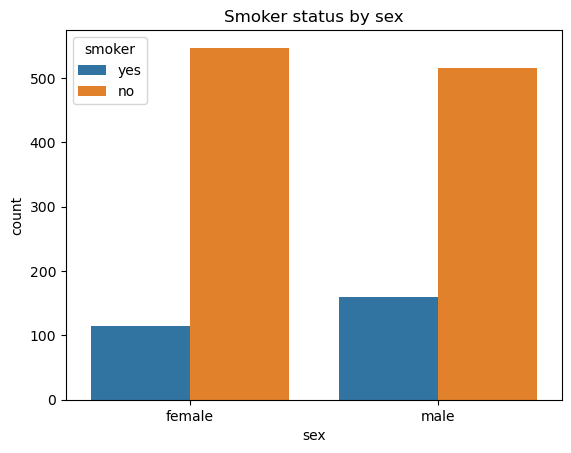

In [112]:
# Visualize male vs female
ax = sns.countplot(df, x = 'sex',hue='smoker')
ax.set_title('Smoker status by sex');

### Q3 - Do different regions have different charges, on average?

#### State the Hypothesis and Null Hypothesis
- H0(Null Hypothesis): All regions have the same insurance charges average.
- HA(Alternate Hypothesis): Some regions have significant difference in insurance charges average.
- Significance level of alpha = 0.05

#### 

- Appropriate test to perform would be:
    - Since we have more than 2 groups 
    - we therefore want to perform ANOVA test
- ANOVA Assumptions 
    - Nomality  
    - Equal Variance
    - No Significant outliers
    

#### Separate the Groups 

In [113]:
## Create groups dictionary
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()



dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [114]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df


,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,324.0,6.502634e-24,106.779670
northeast,324.0,1.455431e-19,86.747629


In [115]:
### checking sig 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df



,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,324.0,6.502634e-24,106.779670,True
northeast,324.0,1.455431e-19,86.747629,True


#### Testing Assumtions of Equal Variance

In [116]:
# with the * operator 
stats.levene(*groups.values())


LeveneResult(statistic=5.553479860699911, pvalue=0.0008689544824002284)

- we failed the assumption for Equal Variance, therefore we will be doing Welch ANOVA test instead

In [117]:
# Import pingouin for welch_anova
import pingouin as pg

In [118]:
# Perform Welch's ANOVA test
pg.welch_anova(dv='charges', between='region',data=df)

,Source,ddof1,ddof2,F,p-unc,np2
0,region,3,740.41575,2.566223,0.053489,0.006542


#### Final conclusion 
- our p > 0.05, we fail to reject the null hypothesis that regions have the same insurance charges average.

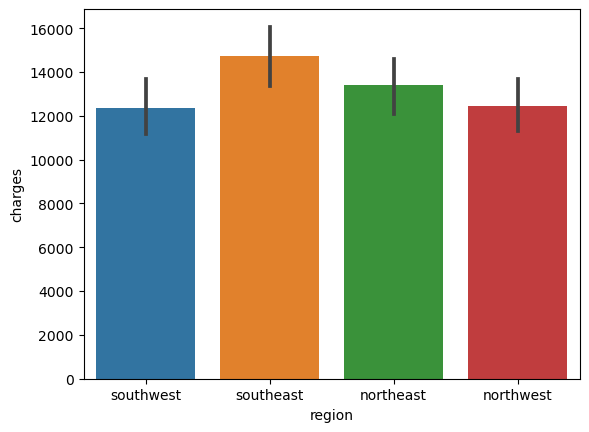

In [119]:
# Visualize means 
ax = sns.barplot(plot_df, x = 'region', y='charges', errorbar=('ci',95))